In [ ]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import random as ra

from skimage.morphology import skeletonize
import networkx as nx
from scipy.ndimage import distance_transform_edt

import os
import re


In [9]:
input_size = 784
hidden_size0 = 32
hidden_size1 = 16     
out_size = 10
        
epochs = 10            
batch_size = 1000 #just for loading more data easily
learning_rate = 0.001

In [10]:
train_dataset = datasets.MNIST(root='./data',
                           train=True,
                           transform=transforms.ToTensor(),
                           download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

test_dataset = datasets.MNIST(root='./data',
                           train=False,
                           transform=transforms.ToTensor())

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [11]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size0, hidden_size1, out_size):
        super(Net, self).__init__()
        self.fc0 = nn.Linear(input_size, hidden_size0)     #784 - 32
        self.fc1 = nn.Linear(hidden_size0, hidden_size1)   #32 - 16
        self.fc2 = nn.Linear(hidden_size1, out_size)       #16 - 10
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        nn.init.kaiming_normal_(self.fc0.weight) #only works with ReLU
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)

    def forward(self, x):
        x0 = self.relu(self.fc0(x))
        x1 = self.relu(self.fc1(x0))
        out = self.fc2(x1) #no ReLU because final decision would be altered, couldn't be "fixed" by other weights anymore, has to stay true!
        return out, [x0, x1, out]

In [12]:
net0 = Net(input_size, hidden_size0, hidden_size1, out_size)
CUDA = torch.cuda.is_available()
if CUDA:
    net0 = net0.cuda()

file_pth = 'model_inst_3' #.pth is a convention, not required, interesting... :) 
net0.load_state_dict(torch.load(file_pth)) #pre-trained

<All keys matched successfully>

In [13]:
with torch.no_grad():
    correct = 0
    for images, labels in test_loader:
        if CUDA:
            images = images.cuda()
            labels = labels.cuda()
        images = images.view(-1, 28*28)
        outputs, _ = net0(images)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / len(test_dataset)))

Accuracy of the network on the 10000 test images: 96.08 %


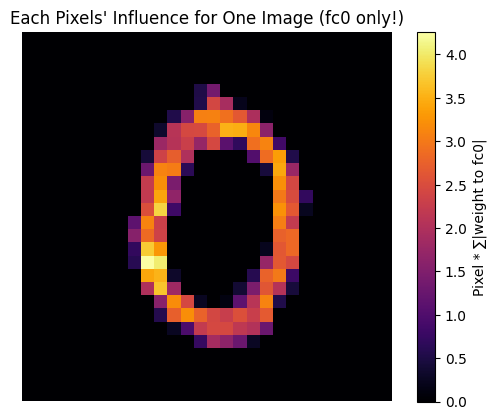

In [14]:
inputs, labels = next(iter(test_loader))
ind = ra.randrange(0, len(inputs))
img = inputs[ind].squeeze() #[28, 28]

weights = net0.fc0.weight.detach().cpu() #[32, 784]
importance = weights.abs().sum(dim=0).view(28, 28) #[28, 28]

activation_fc0 = img * importance #[28, 28] 

plt.imshow(activation_fc0, cmap='inferno', vmin=0, vmax=activation_fc0.max())
plt.colorbar(label='Pixel * ∑|weight to fc0|')
plt.title("Each Pixels' Influence for One Image (fc0 only!)")
plt.axis('off')
plt.show()

/tmp/ipykernel_4658/2352316340.py:110: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


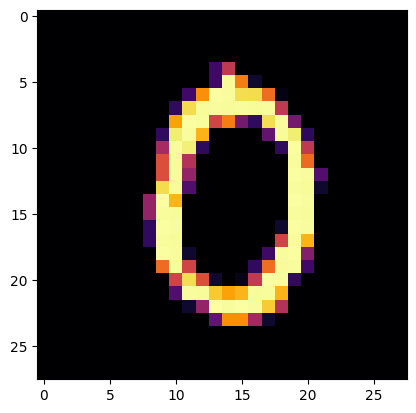

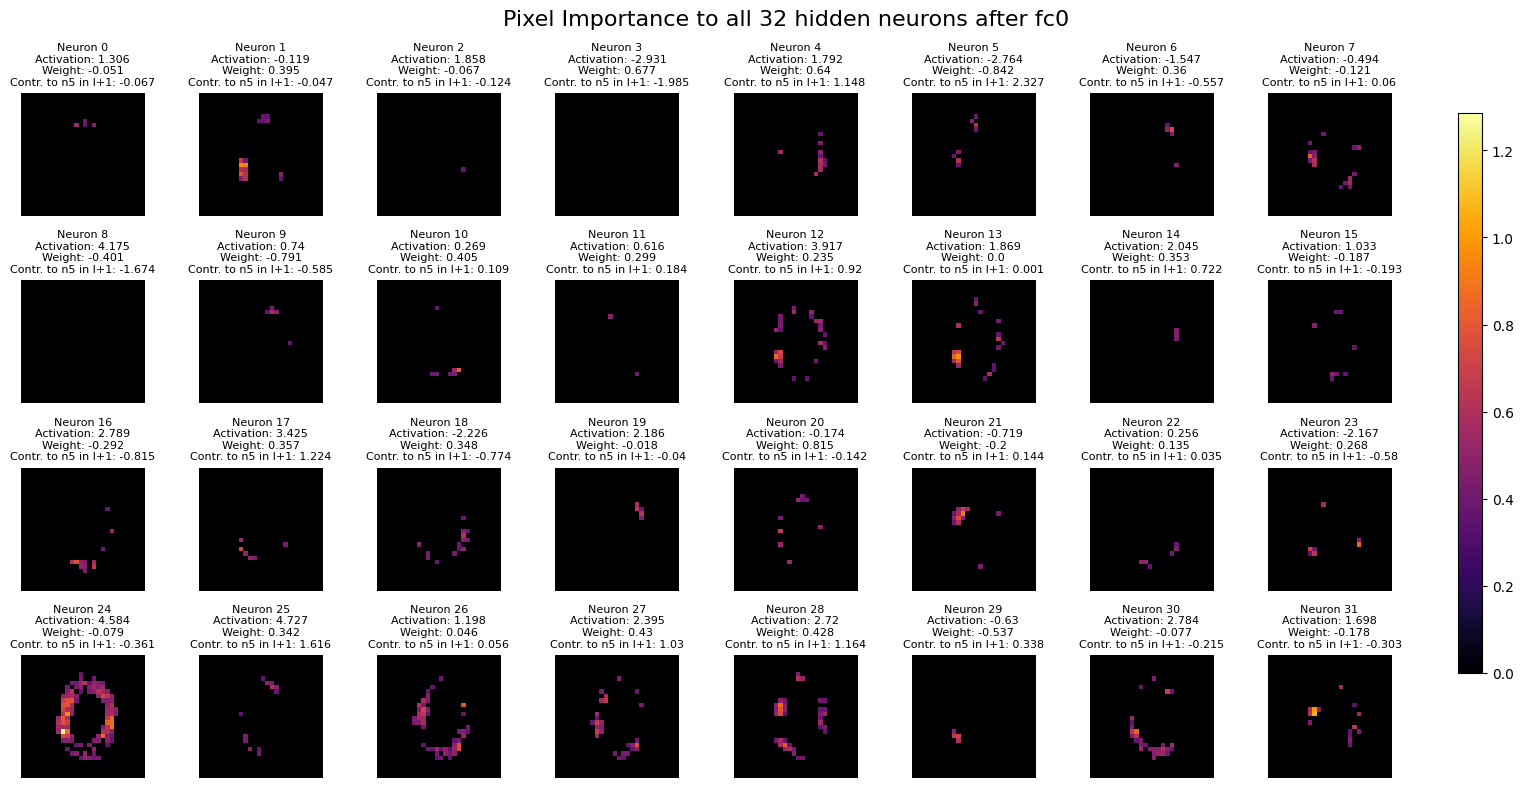

In [15]:

"""inputs, labels = next(iter(test_loader))
dig_to_check = 8

#search wanted digit:
while True:
    ind = ra.randrange(0, len(inputs))
    if labels[ind] == dig_to_check:
        img = inputs[ind].squeeze()
        break"""
    
#img = torch.full((28, 28), 255)

plt.imshow(img, cmap="inferno")
#plt.title(f"Predicted by net: {pred}")

img_flat = img.view(-1)

weights = net0.fc0.weight.detach().cpu()
biases = net0.fc0.bias.detach().cpu()
contribs = weights * img_flat #32, 784

#mask = (img_flat > 0).float()
#contribs = contribs * mask

#contribs = torch.clamp(contribs, min=0.0)

#normalise to [0, 1]
max_val = contribs.max()
contribs_norm = contribs / max_val
contribs_imgs = contribs_norm.view(-1, 28, 28)

mask = torch.where(
    contribs_imgs == 0,
    torch.tensor(0.0, device=contribs_imgs.device),
    1
)

contribs_imgs += biases[:, None, None]
contribs_imgs *= mask #no bias where background = 0

contribs_imgs = torch.where(
    contribs_imgs == 0,
    torch.tensor(0.0, device=contribs_imgs.device),
    torch.where(
        contribs_imgs > 0.35,
        contribs_imgs,
        torch.tensor(0.0, device=contribs_imgs.device)
    )
)

activation_modified = []
for i, mat in enumerate(contribs_imgs):
    mat = mat.sum().item()
    #print(f"{i}: {mat}")
    activation_modified.append(mat)


#combo = contribs_imgs.sum(dim=0)
combo = contribs_imgs.max(dim=0).values

#normalise
#max_val = combo.max()
#combo /= max_val

"""combo = torch.where(
    combo == 0,
    torch.tensor(0.0, device=combo.device),
    torch.where(
        combo > 0.35,
        combo,
        torch.tensor(0.1, device=combo.device)
    )
)"""



"""for i, mat in enumerate(contribs_imgs):
    if i == 0:
        activations = mat.sum(dim=0)
        continue

    activations += mat.sum(dim=0)"""
#instead take actualy activaiton, this is modified for visuals!
activations = net0.fc0(img.view(1, -1).cuda()).squeeze()

next_neuron_idx = 5

weights_to_neuron = net0.fc1.weight[next_neuron_idx]
contribution = activations * weights_to_neuron
#next_contribs = contribution.sum(dim=1) #dim = 1 means y-axis, so all weights to neuron

#print(next_contribs.size())
#print(weights_to_neuron.size())

"""plt.imshow(combo, cmap="inferno")
plt.title("Combined max importasnce of all neurons")"""

fig, axes = plt.subplots(4, 8, figsize=(16, 8))

vmax = contribs_imgs.max().item()

for i, ax in enumerate(axes.flat):
    im = ax.imshow(contribs_imgs[i], cmap='inferno', vmin=0, vmax=vmax)
    ax.set_title(f'Neuron {i}\nActivation: {round(activations[i].item(), 3)}\nWeight: {round(weights_to_neuron[i].item(), 3)}\nContr. to n{next_neuron_idx} in l+1: {round(contribution[i].item(), 3)}', fontsize=8)
    ax.axis('off')

fig.suptitle('Pixel Importance to all 32 hidden neurons after fc0', fontsize=16)
cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()


In [16]:
net1 = Net(input_size, hidden_size0, hidden_size1, out_size)
CUDA = torch.cuda.is_available()
if CUDA:
    net1 = net1.cuda()

file_pth = 'model_inst_1' #.pth is a convention, not required, interesting... :) 
net1.load_state_dict(torch.load(file_pth)) #pre-trained

<All keys matched successfully>

In [17]:
with torch.no_grad():
    correct = 0
    for images, labels in test_loader:
        if CUDA:
            images = images.cuda()
            labels = labels.cuda()
        images = images.view(-1, 28*28)
        outputs, _ = net1(images)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / len(test_dataset)))

Accuracy of the network on the 10000 test images: 96.95 %


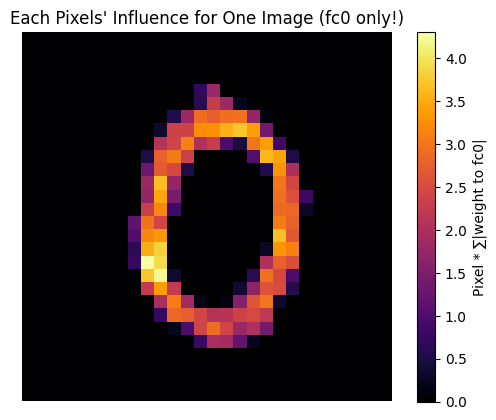

In [18]:
weights1 = net1.fc0.weight.detach().cpu() #[32, 784]
importance1 = weights1.abs().sum(dim=0).view(28, 28) #[28, 28]

activation_fc0_1 = img * importance1 #[28, 28] 

plt.imshow(activation_fc0_1, cmap='inferno', vmin=0, vmax=activation_fc0_1.max())
plt.colorbar(label='Pixel * ∑|weight to fc0|')
plt.title("Each Pixels' Influence for One Image (fc0 only!)")
plt.axis('off')
plt.show()

/tmp/ipykernel_4658/3658588502.py:110: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


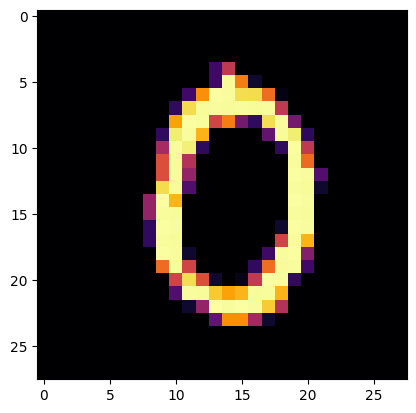

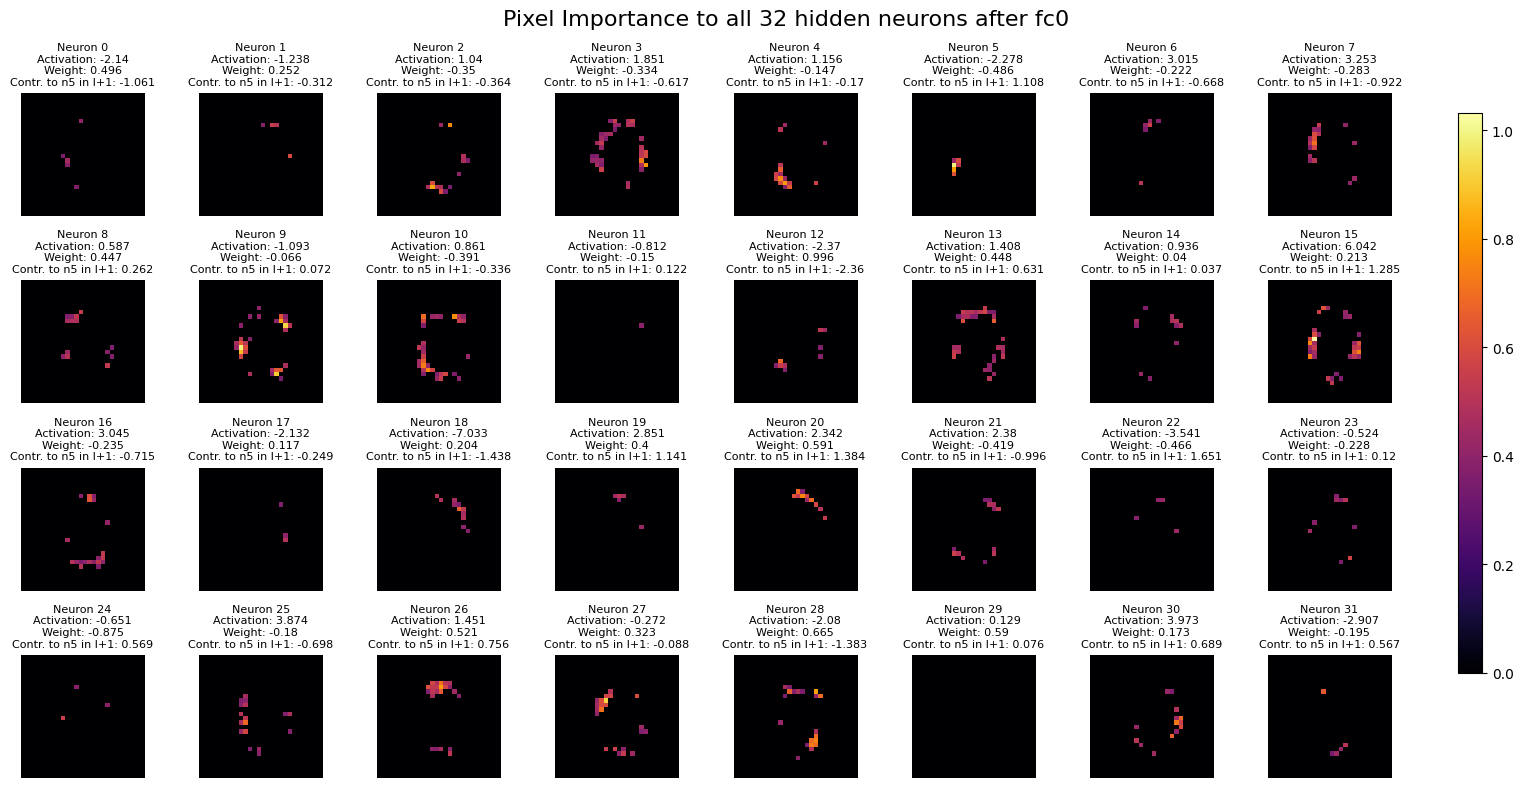

In [19]:

"""inputs, labels = next(iter(test_loader))
dig_to_check = 8

#search wanted digit:
while True:
    ind = ra.randrange(0, len(inputs))
    if labels[ind] == dig_to_check:
        img = inputs[ind].squeeze()
        break"""
    
#img = torch.full((28, 28), 255)

plt.imshow(img, cmap="inferno")
#plt.title(f"Predicted by net: {pred}")

img_flat1 = img.view(-1)

weights1 = net1.fc0.weight.detach().cpu()
biases1 = net1.fc0.bias.detach().cpu()
contribs1 = weights1 * img_flat1 #32, 784

#mask1 = (img_flat1 > 0).float()
#contribs1 = contribs1 * mask1

#contribs1 = torch.clamp(contribs1, min=0.0)

#normalise to [0, 1]
max_val1 = contribs1.max()
contribs_norm1 = contribs1 / max_val1
contribs_imgs1 = contribs_norm1.view(-1, 28, 28)

mask1 = torch.where(
    contribs_imgs1 == 0,
    torch.tensor(0.0, device=contribs_imgs1.device),
    1
)

contribs_imgs1 += biases1[:, None, None]
contribs_imgs1 *= mask1 #no bias where background = 0

contribs_imgs1 = torch.where(
    contribs_imgs1 == 0,
    torch.tensor(0.0, device=contribs_imgs1.device),
    torch.where(
        contribs_imgs1 > 0.35,
        contribs_imgs1,
        torch.tensor(0.0, device=contribs_imgs1.device)
    )
)

activation_modified1 = []
for i, mat in enumerate(contribs_imgs1):
    mat = mat.sum().item()
    #print(f"{i}: {mat}")
    activation_modified1.append(mat)


#combo1 = contribs_imgs1.sum(dim=0)
combo1 = contribs_imgs1.max(dim=0).values

#normalise
#max_val1 = combo1.max()
#combo1 /= max_val1

"""combo1 = torch.where(
    combo1 == 0,
    torch.tensor(0.0, device=combo1.device),
    torch.where(
        combo1 > 0.35,
        combo1,
        torch.tensor(0.1, device=combo1.device)
    )
)"""



"""for i, mat in enumerate(contribs_imgs1):
    if i == 0:
        activations1 = mat.sum(dim=0)
        continue

    activations1 += mat.sum(dim=0)"""
#instead take actualy activaiton, this is modified for visuals!
activations1 = net1.fc0(img.view(1, -1).cuda()).squeeze()

next_neuron_idx1 = 5

weights_to_neuron1 = net1.fc1.weight[next_neuron_idx1]
contribution1 = activations1 * weights_to_neuron1
#next_contribs = contribution1.sum(dim=1) #dim = 1 means y-axis, so all weights to neuron

#print(next_contribs.size())
#print(weights_to_neuron1.size())

"""plt.imshow(combo1, cmap="inferno")
plt.title("Combined max importasnce of all neurons")"""

fig1, axes1 = plt.subplots(4, 8, figsize=(16, 8))

vmax1 = contribs_imgs1.max().item()

for i, ax in enumerate(axes1.flat):
    im = ax.imshow(contribs_imgs1[i], cmap='inferno', vmin=0, vmax=vmax1)
    ax.set_title(f'Neuron {i}\nActivation: {round(activations1[i].item(), 3)}\nWeight: {round(weights_to_neuron1[i].item(), 3)}\nContr. to n{next_neuron_idx1} in l+1: {round(contribution1[i].item(), 3)}', fontsize=8)
    ax.axis('off')

fig1.suptitle('Pixel Importance to all 32 hidden neurons after fc0', fontsize=16)
cbar_ax1 = fig1.add_axes([0.92, 0.15, 0.015, 0.7])
fig1.colorbar(im, cax=cbar_ax1)
plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()


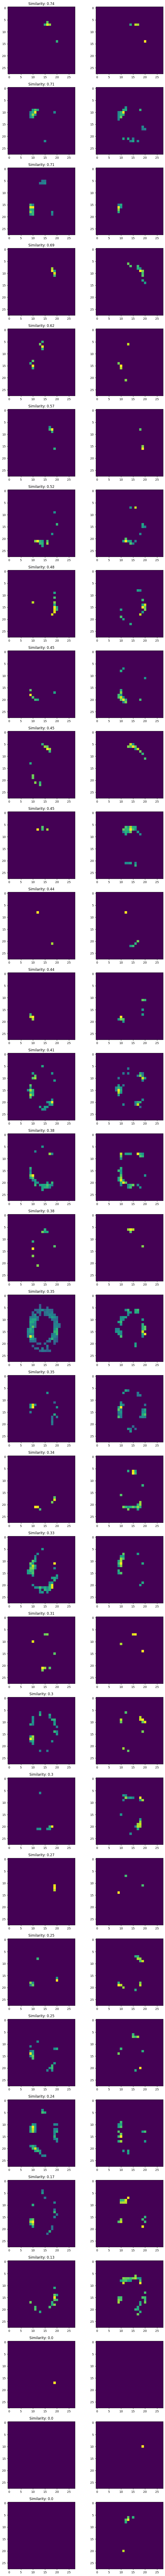

In [20]:
import torch.nn.functional as F
from scipy.optimize import linear_sum_assignment

def normalize_map(t):
    return (t - t.mean()) / (t.std() + 1e-8)

def similarity_score(map1, map2):
    a = normalize_map(map1).view(-1)
    b = normalize_map(map2).view(-1)
    #return torch.norm(a - b, p=2).item()
    return F.cosine_similarity(a.unsqueeze(0), b.unsqueeze(0)).item()


mask = (img != 0)
mask_flat = mask.flatten()

flat_imgs = contribs_imgs.view(contribs_imgs.shape[0], -1)
flat_imgs1 = contribs_imgs1.view(contribs_imgs1.shape[0], -1)

masked_imgs = flat_imgs[:, mask_flat]
masked_imgs1 = flat_imgs1[:, mask_flat]

sim_matrix = torch.zeros((32, 32))

for i in range(32):
    for j in range(32):
        sim_matrix[i, j] = similarity_score(masked_imgs[i], masked_imgs1[j])

cost = -sim_matrix.numpy()
row_ind, col_ind = linear_sum_assignment(cost)
max_vals = sim_matrix[row_ind, col_ind].tolist()

pairs = list(zip(row_ind, col_ind, max_vals))
pairs.sort(key=lambda x: x[2], reverse=True)

plt.figure(figsize=(10, 160))

for i, (r, c, sim) in enumerate(pairs):
    plt.subplot(32, 2, i*2+1)
    plt.imshow(contribs_imgs[r])
    plt.title(f"Similarity: {round(sim, 2)}")
    plt.subplot(32, 2, i*2+2)
    plt.imshow(contribs_imgs1[c])
